In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from lib import *
plt.style.use('../peptidome.mplstyle')
from matplotlib.lines import Line2D

In [2]:
proteomes = ['Human', 'Mouse', 'Chicken', 'Zebrafish', 'Humanviruses', 'Malaria', 'Tuberculosis', 'Listeria', 'StrepA', ]
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
k = 9
dkls = pd.DataFrame(data={ model:
                          [float(pd.read_csv('data/{proteome}_{model}_k{k}_dkl.csv'.format(proteome=proteome,
                                                                            model=model, k=k))['Human'])
                            if not proteome == 'Human' else 0.0 for proteome in proteomes]
                          for model in models}
                    , index=proteomes)
dkls

,independent,ncov,nskew,nskewfcov
Human,0.000000,0.000000,0.000000,0.000000
Mouse,0.002779,0.004223,0.005823,0.008042
Chicken,0.004093,0.008852,0.013786,0.026510
Zebrafish,0.025243,0.031414,0.035085,0.047840
Humanviruses,0.091598,0.118758,0.134797,0.178828
Malaria,2.177257,1.737879,1.834346,1.975289
Tuberculosis,0.701787,0.653004,0.695999,0.788998
Listeria,0.431025,0.428997,0.436824,0.499468
StrepA,0.363996,0.378023,0.383617,0.480075


In [3]:
Sind = np.log(naminoacids)*k
dkls_rand = pd.DataFrame(data={ model:
                          [Sind - float(pd.read_csv('data/{proteome}_{model}_k{k}_entropy.csv'.format(proteome=proteome,
                                                                            model=model, k=k),
                                            index_col=0, header=None).loc['S'])
                            for proteome in proteomes]
                          for model in models}
                    , index=proteomes)
dkls_rand

,independent,ncov,nskew,nskewfcov
Human,0.926214,1.045174,1.098691,1.141816
Mouse,0.903164,1.009821,1.053955,1.106401
Chicken,0.870244,1.002373,1.046072,1.085164
Zebrafish,0.826642,0.910718,0.962889,1.002249
Humanviruses,0.840005,1.029934,1.088658,1.124112
Malaria,2.073610,2.287159,2.326683,2.481378
Tuberculosis,1.871207,1.956671,2.009185,2.093849
Listeria,1.210196,1.252900,1.292349,1.361428
StrepA,1.190008,1.234220,1.269707,1.362927


In [4]:
def mscatter(x,y, ax=None, m=None, **kwargs):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x, y, **kwargs)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        legend_handles = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
            legend_handles.append(Line2D([0], [0], marker=marker, ls=''))
        sc.set_paths(paths)
    return sc, legend_handles

In [5]:
def plot_lineandscatter(x, y, label=None, ax=None, markers=['o', 's', '>', 'd']):
    if not ax:
        ax = plt.gca()
    l, = ax.plot(x, y, ls='-', label=label)
    sc, legend_handles = mscatter(x, y, m=markers, ax=ax, s=10)
    return l, sc, legend_handles

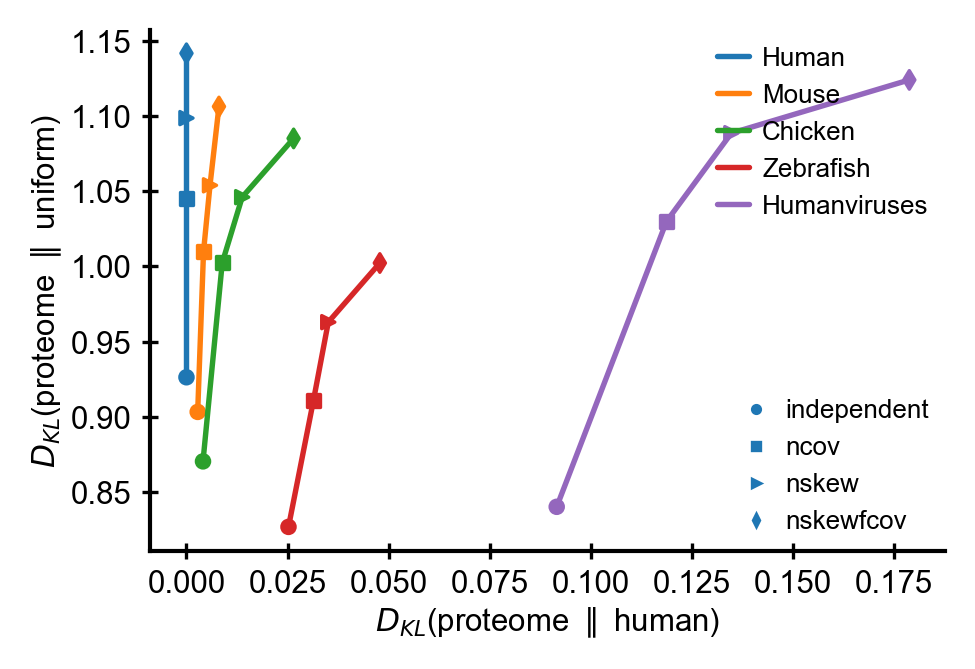

In [6]:
fig, ax = plt.subplots()
for proteome in ['Human', 'Mouse', 'Chicken', 'Zebrafish', 'Humanviruses']:
    l, sc, legend_handles = plot_lineandscatter(dkls.loc[proteome], dkls_rand.loc[proteome], label=proteome)
l1 = ax.legend(ncol=1, loc='upper right')
l2 = ax.legend(legend_handles, models)
ax.add_artist(l1)
ax.set_xlabel('$D_{KL}$(proteome $\parallel$ human)')
ax.set_ylabel('$D_{KL}$(proteome $\parallel$ uniform)');

In [10]:
class smart_dict(dict):
    def __missing__(self, key):
        return key
proteome_to_label = smart_dict()
proteome_to_label['Humanviruses'] = 'Human Virome'
proteome_to_label['Malaria'] = 'P. falciparum'

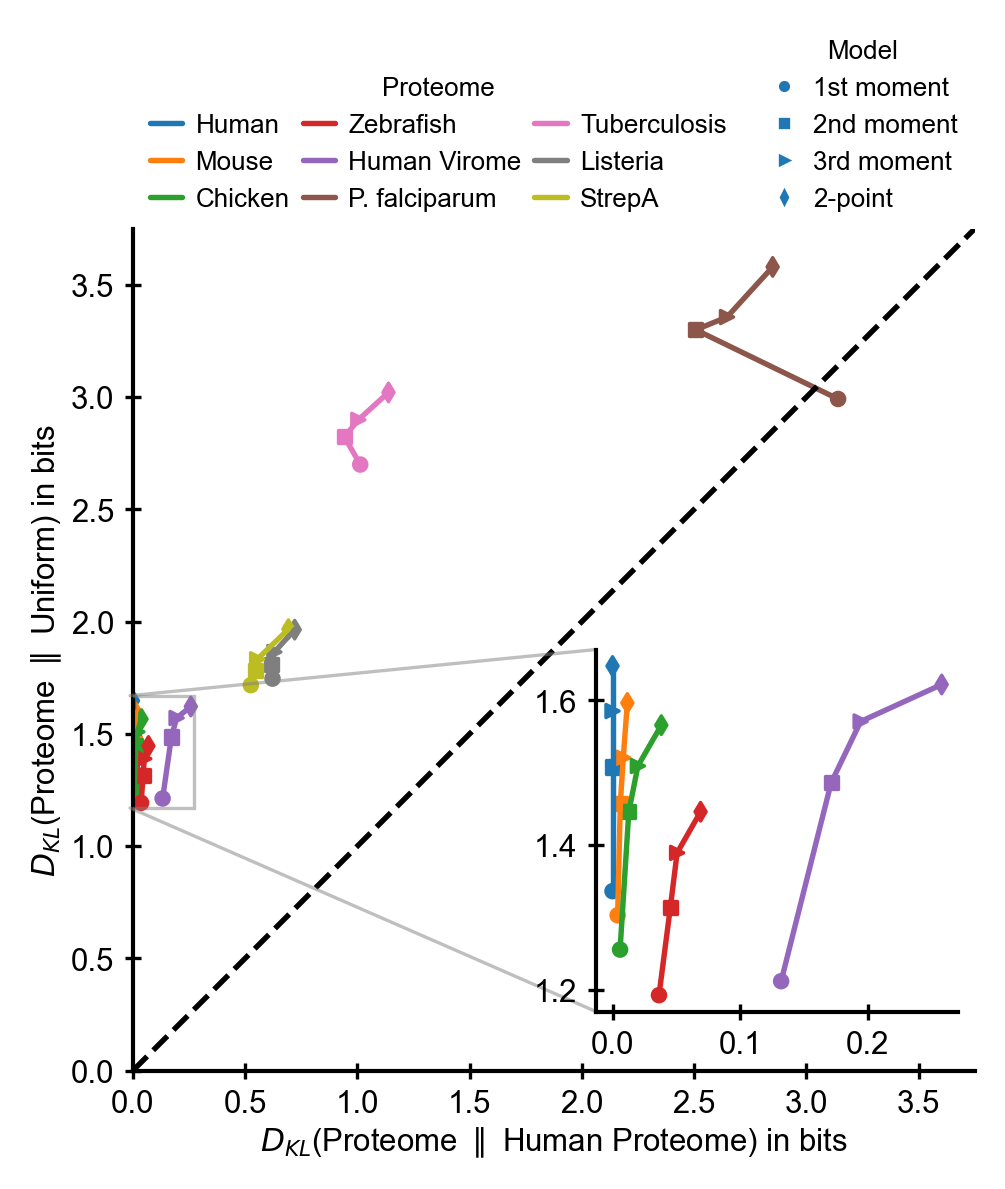

In [13]:
nattobits = np.log2(np.exp(1))
lim = 2.6*nattobits
fig, ax = plt.subplots(figsize=(3.42, 4.0))
for proteome in proteomes:
    l, sc, legend_handles = plot_lineandscatter(dkls.loc[proteome]*nattobits,
                                                dkls_rand.loc[proteome]*nattobits,
                                                label=proteome_to_label[proteome],
                                                ax=ax)
ax.plot([0, lim], [0, lim], 'k--')
l1 = ax.legend(ncol=3, loc='lower left',
               title='Proteome', bbox_to_anchor=(0.0, 1.0))
l2 = ax.legend(legend_handles, [model_labels[m] for m in models],
               loc='lower right', title='Model', ncol=1, bbox_to_anchor=(1.0, 1.0))
ax.add_artist(l1)
ax.set_xlim(-0.0, lim)
ax.set_ylim(-0.0, lim)
ax.set_xlabel('$D_{KL}$(Proteome $\parallel$ Human Proteome) in bits')
ax.set_ylabel('$D_{KL}$(Proteome $\parallel$ Uniform) in bits')
ax.set_aspect('equal')

axins = ax.inset_axes((0.55, 0.07, 0.43, 0.43))
for proteome in ['Human', 'Mouse', 'Chicken', 'Zebrafish', 'Humanviruses']:
    plot_lineandscatter(dkls.loc[proteome]*nattobits, dkls_rand.loc[proteome]*nattobits, label=proteome, ax=axins)
rectangle_patch, connector_lines = ax.indicate_inset_zoom(axins)
#lower_left, upper_left, lower_right, upper_right = connector_lines

fig.tight_layout()
fig.savefig(figuredir + 'dkls.svg')
